# Final Project

Kyle Mann

December 6, 2021

1. Data Cleaning

1.1 Upload dataset

The dataset is a dataset originally obtained from the Bondora public API. Each record in the dataset represents a loan initiated on Bondora, a peer-to-peer lending service. All of the loans originate in Estonia, Finland, Spain, or  Slovakia.

The dataset is available on Kaggle at the link https://www.kaggle.com/sid321axn/bondora-peer-to-peer-lending-loan-data

Metadata on the columns is available at https://www.bondora.com/en/public-reports



1.2 Import packages

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import math
import seaborn as sns
import statistics as stat
from matplotlib import pyplot as plt

1.3 Import Dataset



In [3]:
bond_full_raw = pd.read_csv('LoanData_Bondora.csv', dtype={"NrOfDependants": str, "WorkExperience": str,
                                                          "Rating_V0": str, "Rating_V1": str, "Rating_V2": str,
                                                          "CreditScoreEsEquifaxRisk": str, 
                                                           "CreditScoreFiAsiakasTietoRiskGrade": str})
print(bond_full_raw.shape)

(179235, 112)


1.4 Column Subset

The full dataset has 179,235 records and 112 columns.

The following types of variables are dropped:
  - ID variables
  - Data on the loan origination process such as # of bids
  - Variables that fall chronoligically post-default
  - Potential predictors for which the majority of the values are missing such as WorkExperience, OccupationArea, DebtToIncome, etc.
  - Results of Bondora's in-house credit risk modeling such as Rating, ExpectedLoss, ExpectedReturn, ProbabilityOfDefault, etc.

The following types of variables are kept:
  - Dates of loan origination and default
  - Loan amount and maximum interest rate
  - Potential predictors that have few missing values such as 

In [4]:
rawdata_drop_vars = ['ReportAsOfEOD', 'LoanId', 'LoanNumber', 'ListedOnUTC', 'BiddingStartedOn', 
 'BidsPortfolioManager', 'LoanApplicationStartedDate', 'ApplicationSignedHour', 
 'ApplicationSignedWeekday', 'DateOfBirth', 'County', 'City', 'EmploymentPosition', 
 'MonthlyPaymentDay', 'EL_V0', 'Rating_V0', 'EL_V1', 'Rating_V1', 'Rating_V2', 
 'CreditScoreEsEquifaxRisk', 'CreditScoreFiAsiakasTietoRiskGrade', 'CreditScoreEeMini', 
 'NextPaymentDate', 'NextPaymentNr', 'PrincipalRecovery', 'InterestRecovery', 
 'RecoveryStage', 'StageActiveSince', 'Status', 'Restructured', 'ActiveLateCategory', 
 'WorseLateCategory', 'PrincipalDebtServicingCost', 'InterestAndPenaltyDebtServicingCost', 
 'ActiveLateLastPaymentCategory', 'PrincipalPaymentsMade', 'InterestAndPenaltyPaymentsMade', 
 'PrincipalWriteOffs', 'InterestAndPenaltyWriteOffs', 'PrincipalBalance', 
 'InterestAndPenaltyBalance', 'GracePeriodStart', 'GracePeriodEnd', 'UserName', 
 'BidsApi', 'BidsManual', 'LanguageCode', 'IncomeFromPrincipalEmployer', 'IncomeFromPension', 
 'IncomeFromFamilyAllowance', 'IncomeFromSocialWelfare', 'IncomeFromLeavePay', 
 'IncomeFromChildSupport', 'IncomeOther', 'PlannedPrincipalTillDate', 'CurrentDebtDaysPrimary', 
 'DebtOccuredOn', 'CurrentDebtDaysSecondary', 'DebtOccuredOnForSecondary', 'AppliedAmount',
 'ExpectedLoss', 'LossGivenDefault', 'ExpectedReturn', 'ProbabilityOfDefault', 
 'ModelVersion', 'Rating', 'CreditScoreEsMicroL','EmploymentStatus', 'NrOfDependants', 
 'MaritalStatus', 'UseOfLoan', 'WorkExperience', 'OccupationArea', 'RefinanceLiabilities', 
 'DebtToIncome', 'FreeCash',
 'MaturityDate_Original', 'MaturityDate_Last', 'ReScheduledOn', 'ContractEndDate',
 'ActiveScheduleFirstPaymentReached', 'PlannedInterestTillDate', 'LastPaymentOn',
 'NrOfScheduledPayments', 'PreviousEarlyRepaymentsBefoleLoan', 'PreviousEarlyRepaymentsCountBeforeLoan',
 'EAD1', 'EAD2', 'PrincipalOverdueBySchedule', 'PlannedPrincipalPostDefault', 'PlannedInterestPostDefault']

rawdata_keep_vars = ['NewCreditCustomer', 'LoanDate', 'VerificationType', 'Age', 'Gender', 'Country', 
 'Amount', 'Interest', 'LoanDuration', 'MonthlyPayment', 
 'EmploymentDurationCurrentEmployer', 'Education', 'HomeOwnershipType', 'IncomeTotal', 
 'ExistingLiabilities', 'LiabilitiesTotal', 'DefaultDate', 
 'NoOfPreviousLoansBeforeLoan', 'AmountOfPreviousLoansBeforeLoan', 
 'PreviousRepaymentsBeforeLoan', 'FirstPaymentDate']

# Subset to relevant columns
bond_restricted_columns = bond_full_raw[rawdata_keep_vars].copy()

# Crate year of loan origination as character variable
bond_restricted_columns['LoanYear'] = [x for x in bond_restricted_columns['LoanDate'].str.slice(0,4)]

1.5 Row Subset

The years of loan origination range from 2009 to 2021, plotted below.
We will attempt to build a model for probability of default. Because default may occur some time after the loan origination, we will drop the more recent records. Because about 90% of the loans that defaulted did so within 2.5 years, we will drop the loans originating in 2019 onward. Also, to keep the data size within the parameters of the project assignment, we will also drop loans originating in 2016 or earlier, and only include on loans originating in 2017 or 2018.

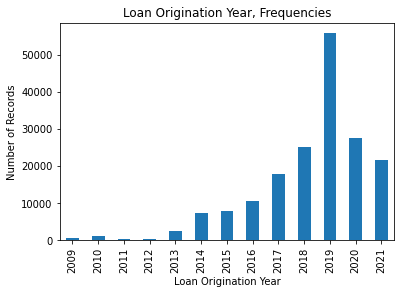

In [ ]:
# Plot # of records by loan origination year
bond_restricted_columns['LoanYear'].value_counts(dropna=False).sort_index().plot.bar()
plt.title("Loan Origination Year, Frequencies")
plt.ylabel('Number of Records')
plt.xlabel('Loan Origination Year')
plt.show()

In [ ]:
# Subset to records with loan origination dates in 2017 or 2018
bond0 = bond_restricted_columns.loc[[(2017 <= int(x)) & (int(x) <= 2018) for x in bond_restricted_columns['LoanYear']]].copy()
print(bond0.shape)

(43036, 22)


After the removal of unused columns and rows, the dataset is 43,036 records and 22 variables.

1.6 Data Preprocessing

- Variables that rely on numeric codes are decoded according to the metadata at https://www.bondora.com/en/public-reports.
- Categorical variables are recoded as dummy variables for input into models such as logistic regression.
- Time from origination to default is computed.
- A binary indicator Y/N variable for default is computed based on date of default. This will be the primary response variable in the analysis.

In [ ]:
bond1 = bond0.copy()

##################################################
# VerificationType represents how financial verification was done
# Convert numeric code to character values (based on metadata)
def make_VerificationType_c(x): 
    if (x == 4): return 'Income and expenses verified'
    elif (x == 3): return 'Income verified'
    elif (x == 2): return 'Income unverified, cross-referenced by phone'
    elif (x == 1): return 'Income unverified'
    elif (x == 0): return 'Not set'
    else:
        assert(math.isnan(x))
        return ''
bond1['VerificationType_c'] = bond1['VerificationType'].apply(make_VerificationType_c)

# VerificationType has 5 categories, but for the sake of analysis, we can condense to 'Verified', 'Unverified', and missing
def make_VerificationType_binary(x): 
    if (x in ('Income and expenses verified', 'Income verified')): return 'Verified'
    elif (x in ('Income unverified, cross-referenced by phone', 'Income unverified')): return 'Unverified'
    elif (x in ('Not set', '')): return ''
    else: assert(False)
bond1['VerificationType_binary'] = bond1['VerificationType_c'].apply(make_VerificationType_binary)

# Dummy indicator variables
bond1['temp'] = bond1['VerificationType_binary']
bond1 = pd.get_dummies(bond1, columns=['VerificationType_binary'], drop_first=False)
bond1['VerificationType_binary'] = bond1['temp']

##################################################
# Age
# Ages range from 18 to 77, but a few outliers are 0, 1, or 2. We set these values to missing.
# Set the values that are 0/1/2 to missing
bond1.loc[bond1['Age'].isin((0, 1, 2, 3)), 'Age'] = np.nan

##################################################
# Gender
# Convert numeric code to character values (based on metadata)
def make_Gender_c(x): 
    if (x == 0): return 'Male'
    elif (x == 1): return 'Woman'
    elif (x == 2): return 'Undefined'
    else: assert(math.isnan(x))
bond1['Gender_c'] = bond1['Gender'].apply(make_Gender_c)

# Dummy indicator variables
bond1['temp'] = bond1['Gender_c']
bond1 = pd.get_dummies(bond1, columns=['Gender_c'], drop_first=False)
bond1['Gender_c'] = bond1['temp']

##################################################
# Eduction
# Convert numeric code to character values (based on metadata)
def make_Education_c(x): 
    if (x == 1): return 'Primary education'
    elif (x == 2): return 'Basic education'
    elif (x == 3): return 'Vocational education'
    elif (x == 4): return 'Secondary education'
    elif (x == 5): return 'Higher education'
    else:
        assert(math.isnan(x) | (x == -1))
        return ''
bond1['Education_c'] = bond1['Education'].apply(make_Education_c)

# VerificationType has 5 categories, but for the sake of analysis, we can condense to 'Primary' and 'Secondary', and missing
def make_Education_simple(x): 
    if (x in ('Primary education', 'Basic education', 'Vocational education')): return 'Primary Education'
    elif (x in ('Higher education', 'Secondary education')): return 'Secondary Education'
    elif (x in ('')): return ''
    else: assert(False)
bond1['Education_simple'] = bond1['Education_c'].apply(make_Education_simple)

# Dummy indicator variables
bond1['temp'] = bond1['Education_simple']
bond1 = pd.get_dummies(bond1, columns=['Education_simple'], drop_first=False)
bond1['Education_simple'] = bond1['temp']

##################################################
# Home Ownership Type
# Convert numeric code to character values (based on metadata)
def make_HomeOwnershipType_c(x): 
    if (x == 1): return 'Owner'
    elif (x == 2): return 'Living with parents'
    elif (x == 3): return 'Tenant, pre-furnished property'
    elif (x == 4): return 'Tenant, unfurnished property'
    elif (x == 5): return 'Council house'
    elif (x == 6): return 'Joint tenant'
    elif (x == 7): return 'Joint ownership'
    elif (x == 8): return 'Mortgage'
    elif (x == 9): return 'Owner with encumbrance'
    elif (x == 10): return 'Other'
    else:
        assert(math.isnan(x) | (x == -1))
        return ''
bond1['HomeOwnershipType_c'] = bond1['HomeOwnershipType'].apply(make_HomeOwnershipType_c)

# VerificationType has 10 categories, but for the sake of analysis, we can condense to 'Owner' and 'Tenant', 'Other', and missing
def make_HomeOwnershipType_simple(x): 
    if (x in ('Owner', 'Owner with encumbrance', 'Mortgage', 'Joint ownership')): return 'Owner'
    elif (x in ('Council house', 'Tenant, unfurnished property', 'Tenant, pre-furnished property', 'Joint tenant')):
        return 'Tenant'
    elif (x in ('Other', 'Living with parents', 'Homeless')): return 'Other'
    elif (x in ('')): return ''
    else: assert(False)
bond1['HomeOwnershipType_simple'] = bond1['HomeOwnershipType_c'].apply(make_HomeOwnershipType_simple)

# Dummy indicator variables
bond1['temp'] = bond1['HomeOwnershipType_simple']
bond1 = pd.get_dummies(bond1, columns=['HomeOwnershipType_simple'], drop_first=False)
bond1['HomeOwnershipType_simple'] = bond1['temp']

##################################################
# EmploymentDurationCurrentEmployer
# Employment duration is a categorical variable. 
# Some categories indicate # of years such as UpTo1Year, UpTo2Years, etc.
# There are also categories for retirees and other.
# We reformat this variable as three features:
#     1. EmploymentDurationCurrentEmployer_n - Numeric variable that represents # of years. If category cannot be converted to years, set as -1.
#     2. EmploymentDuration_Other - Indicator variable for Other category
#     3. Indicator variable for Retiree category
bond1.loc[bond1['EmploymentDurationCurrentEmployer'].isnull(), 'EmploymentDurationCurrentEmployer'] = '' # Reformat missing values
def make_EmploymentDurationCurrentEmployer_n(x): 
    if( x == 'Other'): return -1
    elif( x == 'Retiree'): return -1
    elif( x == 'TrialPeriod'): return 0
    elif( x == 'UpTo1Year'): return 1
    elif( x == 'UpTo2Years'): return 2
    elif( x == 'UpTo3Years'): return 3
    elif( x == 'UpTo4Years'): return 4
    elif( x == 'UpTo5Years'): return 5
    elif( x == 'MoreThan5Years'): return 6
    elif( x == ''): return -1
    else: assert(False)
bond1['EmploymentDurationCurrentEmployer_n'] = bond1['EmploymentDurationCurrentEmployer'].apply(make_EmploymentDurationCurrentEmployer_n)
bond1['EmploymentDuration_Other'] = (bond1['EmploymentDurationCurrentEmployer'] == 'Other') | (bond1['EmploymentDurationCurrentEmployer'].isnull())
bond1['EmploymentDuration_Retiree'] = (bond1['EmploymentDurationCurrentEmployer'] == 'Retiree')

##################################################        
# Loan Initiation Date - Convert to Datetime
bond1['LoanDate_dt'] = pd.to_datetime(bond1['LoanDate'])
bond1['LoanDate_dt_since2017'] = (bond1['LoanDate_dt'] - pd.to_datetime('2017-01-01')).dt.days

##################################################        
# Loan Default Date - Convert to Datetime
bond1['DefaultDate_dt'] = pd.to_datetime(bond1['DefaultDate'])

##################################################        
# IncomeTotal - Convert to log scale
bond1['IncomeTotal'] = [min(x, 7500) for x in bond1['IncomeTotal']] # Cut off max at 10000. Some large outliers are likely entry errors
bond1['IncomeTotal_log'] = [math.log(1+x) for x in bond1['IncomeTotal']] # log transform


##################################################        
# LiabilitiesTotal - Convert to log scale
bond1['LiabilitiesTotal'] = [min(x, 4000) for x in bond1['LiabilitiesTotal']] # Cut off max at 4000 due to large outliers
bond1['LiabilitiesTotal_log'] = [math.log(1+x) for x in bond1['LiabilitiesTotal']] # log transform
bond1['LiabilitiesTotal_none'] = [(x == 0) for x in bond1['LiabilitiesTotal']]

##################################################        
# MonthlyPayment - Convert to log scale
bond1['MonthlyPayment_log'] = [math.log(1+x) for x in bond1['MonthlyPayment']] # log transform

##################################################        
# Default binary indicator variable - Primary response variable
bond1['Default_Binary'] = ['N' if x == True else 'Y' for x in bond1['DefaultDate'].isnull()]
bond1['Default_Binary_n'] = [0 if x == True else 1 for x in bond1['DefaultDate'].isnull()]

##################################################        
# Time to Default (days)
bond1['TimeToDefault'] = (bond1['DefaultDate_dt'] - bond1['LoanDate_dt']).dt.days

##################################################        
# Time to First Payment Date (days)
bond1['FirstPaymentDate_dt'] = pd.to_datetime(bond1['FirstPaymentDate'])
bond1['TimeToFirstPayment'] = (bond1['FirstPaymentDate_dt'] - bond1['LoanDate_dt']).dt.days

##################################################
# AmountOfPreviousLoansBeforeLoan  - Convert to log scale
bond1['AmountOfPreviousLoansBeforeLoan_log'] = [math.log(1+x) for x in bond1['AmountOfPreviousLoansBeforeLoan']] # log transform

##################################################
# Country
# Dummy indicator variables
bond1['temp'] = bond1['Country']
bond1 = pd.get_dummies(bond1, columns=['Country'], drop_first=False)
bond1['Country'] = bond1['temp']

##################################################
# Completely random variable for testing
bond1['randomvar'] = np.random.rand(bond1.shape[0])

2. Data Summary

2.1 Univariate Summaries

For the analysis of loan default probability, we plan to use the following variables:

Response variable: Did Default Occur?

Predictor variables: Country, total income, monthly loan payment amount, home ownership type, education type, duration of most recent employment, age, new credit customer, type of financial verification, time to first planned payment, and current liabilities

To get familiar with the data, we will take a look at each of these features.

In [ ]:
# Utility functions

# Add pct to counts
def count_to_pct(x):
  return(str(x) + '   ' + str(round(100 * x / bond1.shape[0], 1)) + '%')

# Show categorical counts & pct
def show_counts(var):
  x = bond1[var].value_counts(dropna=False)
  y = x.apply(count_to_pct)
  print(y)
  
# Get % of vector that is 'Y'
def get_yes_pct(vec):
    return(str(round(100 * sum(vec=='Y')/len(vec), 1)) + '%')

# Get % of dataset that had default
def show_default_pct(ds, printtext):
  print(printtext + ' - Default rate ' + get_yes_pct(ds['Default_Binary']))

# Pearson correlations
from scipy.stats import pearsonr
def compute_nonna_corr(var1, var2):
    nas = np.logical_or(np.isnan(bond1[var1]), np.isnan(bond1[var2]))
    return(pearsonr(bond1[var1][~nas], bond1[var2][~nas])[0])


2.1.1 Did Default Occur?

Default occurred for 52.8% of the records in the entire dataset

In [ ]:
show_default_pct(bond1, 'Entire data')

Entire data - Default rate 52.8%


2.1.2 Country

The three countries in the data for 2017/2018 are Estonia with 16,946 records, Finland with 9,182 records, and Spain with 5,799 records. 

There is a marked difference in default rate between the three countries with Estonia's default rate at around 42% and the default rate for Finland and Spain around 73%.

In [ ]:
show_counts('Country')
print()
show_default_pct(bond1.loc[bond1['Country'] == 'EE'], 'Estonia')
show_default_pct(bond1.loc[bond1['Country'] == 'FI'], 'Finland')
show_default_pct(bond1.loc[bond1['Country'] == 'ES'], 'Spain')

EE    28055   65.2%
FI     9182   21.3%
ES     5799   13.5%
Name: Country, dtype: object

Estonia - Default rate 42.2%
Finland - Default rate 72.8%
Spain - Default rate 73.0%


###2.1.3 Total income

The median income is 1200 Eur/month.

Little correlation between income and default outcome is observable from a boxplot.

1200.0


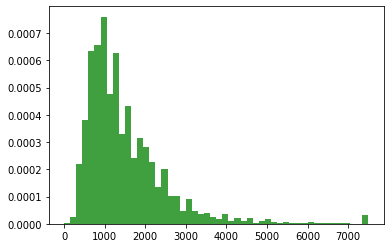

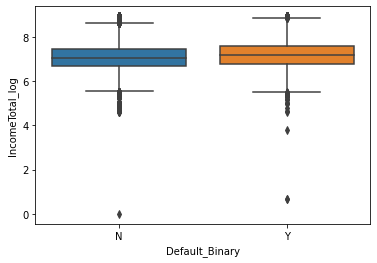

In [ ]:
# the histogram of the data
print(stat.median(bond1['IncomeTotal']))
plt.hist(bond1['IncomeTotal'], 50, density=True, facecolor='g', alpha=0.75)
plt.show()

# Boxplot
sns.boxplot(data=bond1, x='Default_Binary', y='IncomeTotal_log')

2.1.4 Monthly Loan Payment Amount

Most monthly payments for initiated loans are <500 Eur/month with the median being 79 Eur/month.

A boxplot indicates that there may be slight positive correlation between monthly payment amount and default outcome.

79.44


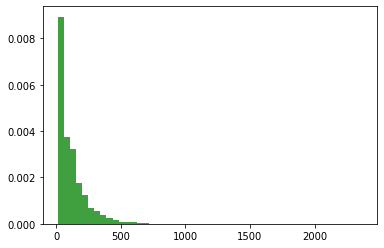

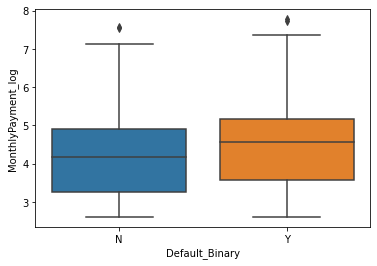

In [ ]:
# the histogram of the data
print(stat.median(bond1['MonthlyPayment']))
plt.hist(bond1['MonthlyPayment'], 50, density=True, facecolor='g', alpha=0.75)
plt.show()

# Boxplot
sns.boxplot(data=bond1, x='Default_Binary', y='MonthlyPayment_log')

2.1.5 Home Ownership Type

About half of borrowers are home owners, with the rest split between being tenants or halving other housing situations.

Default rate appears to be correlated with home ownership type, with 48% default rate for home owners, 56% for the 'other' category, and 61% for tenants.

In [ ]:
show_counts('HomeOwnershipType_simple')
print()

show_default_pct(bond1.loc[bond1['HomeOwnershipType_simple'] == 'Owner'], 'Owner')
show_default_pct(bond1.loc[bond1['HomeOwnershipType_simple'] == 'Other'], 'Other')
show_default_pct(bond1.loc[bond1['HomeOwnershipType_simple'] == 'Tenant'], 'Tenant')

Owner     23662   55.0%
Tenant    10802   25.1%
Other      8569   19.9%
               3   0.0%
Name: HomeOwnershipType_simple, dtype: object

Owner - Default rate 48.0%
Other - Default rate 56.0%
Tenant - Default rate 60.9%


###2.1.6 Education Type

About 1/3 of borrowers have primary education and 2/3 secondary education.

Default rate appears to be correlated with education, with 63% default rate for borrowers with primary education and 48% default rate for borrowers with secondary education.

In [ ]:
show_counts('Education_simple')
print()

show_default_pct(bond1.loc[bond1['Education_simple'] == 'Secondary Education'], 'Secondary Education')
show_default_pct(bond1.loc[bond1['Education_simple'] == 'Primary Education'], 'Primary Education')

Secondary Education    29382   68.3%
Primary Education      13650   31.7%
                            4   0.0%
Name: Education_simple, dtype: object

Secondary Education - Default rate 48.3%
Primary Education - Default rate 62.7%


###2.1.7 Duration of Most Recent Employment

Out of the durations of most recent employment, it appears that retirees may have a higher default rate (66%) than other groups, though not much other trend is apparent.

In [ ]:
show_counts('EmploymentDurationCurrentEmployer')
print()

show_default_pct(bond1.loc[bond1['EmploymentDurationCurrentEmployer_n'] == 0], 'TrialPeriod')
show_default_pct(bond1.loc[bond1['EmploymentDurationCurrentEmployer_n'] == 1], 'UpTo1Year')
show_default_pct(bond1.loc[bond1['EmploymentDurationCurrentEmployer_n'] == 2], 'UpTo2Years')
show_default_pct(bond1.loc[bond1['EmploymentDurationCurrentEmployer_n'] == 3], 'UpTo3Years')
show_default_pct(bond1.loc[bond1['EmploymentDurationCurrentEmployer_n'] == 4], 'UpTo4Years')
show_default_pct(bond1.loc[bond1['EmploymentDurationCurrentEmployer_n'] == 5], 'UpTo5Years')
show_default_pct(bond1.loc[bond1['EmploymentDurationCurrentEmployer_n'] == 6], 'MoreThan5Years')
show_default_pct(bond1.loc[bond1['EmploymentDuration_Other'] == True], 'Other')
show_default_pct(bond1.loc[bond1['EmploymentDuration_Retiree'] == True], 'Retiree')


MoreThan5Years    17463   40.6%
UpTo5Years        10186   23.7%
UpTo1Year          7563   17.6%
Retiree             2048   4.8%
UpTo2Years          1827   4.2%
UpTo3Years          1557   3.6%
Other               1153   2.7%
UpTo4Years           984   2.3%
TrialPeriod          254   0.6%
                       1   0.0%
Name: EmploymentDurationCurrentEmployer, dtype: object

TrialPeriod - Default rate 52.0%
UpTo1Year - Default rate 52.8%
UpTo2Years - Default rate 57.0%
UpTo3Years - Default rate 54.1%
UpTo4Years - Default rate 50.0%
UpTo5Years - Default rate 49.6%
MoreThan5Years - Default rate 52.6%
Other - Default rate 57.1%
Retiree - Default rate 65.9%


2.1.8 Age

Age ranges from 18 to 77. No correlation with default rate is apparent.

40.0


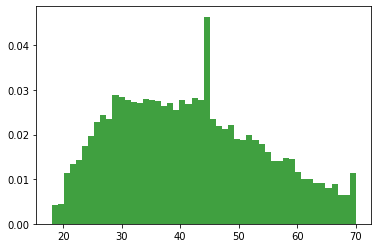

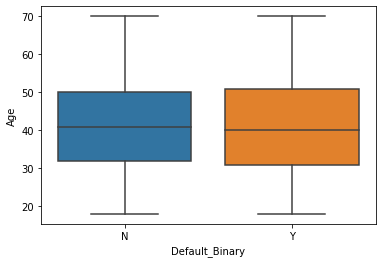

In [ ]:
# the histogram of the data
print(stat.median(bond1['Age']))
plt.hist(bond1['Age'], 50, density=True, facecolor='g', alpha=0.75)
plt.show()

# Boxplot
sns.boxplot(data=bond1, x='Default_Binary', y='Age')

2.1.9 New Credit Customer

Borrowers who are new credit customers have a higher default rate at 61% than those who are not at 46%.

In [ ]:
show_counts('NewCreditCustomer')
print()

show_default_pct(bond1.loc[bond1['NewCreditCustomer'] == True], 'New Credit Customer')
show_default_pct(bond1.loc[bond1['NewCreditCustomer'] == False], 'NOT New Credit Customer')

False    23435   54.5%
True     19601   45.5%
Name: NewCreditCustomer, dtype: object

New Credit Customer - Default rate 60.9%
NOT New Credit Customer - Default rate 46.1%


2.1.10 Type of Financial Verification

In one of the largest surprises of the exploratory analysis, borrowers with no income verification have lower default rate (47%) than those who do (57%).

It is important to remember that this data is not a random sample of the potential borrowing population, but represents loans initiated at Bondora. It is possible that financial verification was only required for what Bondora judged to be riskier loans, hence the higher default rate.

In [ ]:
show_counts('VerificationType_binary')
print()

show_default_pct(bond1.loc[bond1['VerificationType_binary'] == 'Verified'], 'Verified')
show_default_pct(bond1.loc[bond1['VerificationType_binary'] == 'Unverified'], 'Unverified')

Verified      24179   56.2%
Unverified    18857   43.8%
Name: VerificationType_binary, dtype: object

Verified - Default rate 57.1%
Unverified - Default rate 47.3%


2.1.11 Time to First Planned Payment

Time to first planned payment ranges from about 30 to 60 days and has no visible correlation with default rate.

47.0


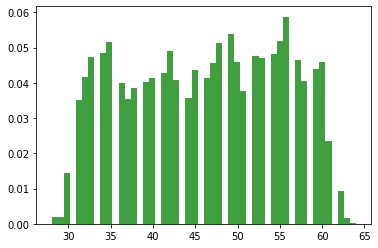

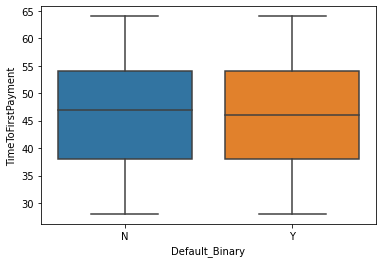

In [ ]:
# the histogram of the data
print(stat.median(bond1['TimeToFirstPayment']))
plt.hist(bond1['TimeToFirstPayment'], 50, density=True, facecolor='g', alpha=0.75)
plt.show()

# Boxplot
sns.boxplot(data=bond1, x='Default_Binary', y='TimeToFirstPayment')

2.1.12 Date of Loan Initiation

From the boxplot, it appears that the default rate decreased over time for the loans originated in 2017 and 2018. This may simply be due to the fact that the data was extracted in summer 2021, and so the 2018 loans were observed for a shorter period of time. To account for this, the number of days since 2017 will be included as a variable in the models. Another approach (likely preferable) would be to compute an alternate default outcome variable that only includes defaults within a certain timeframe (say 2 years).

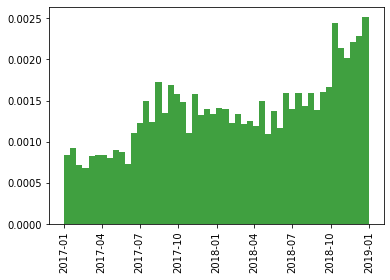

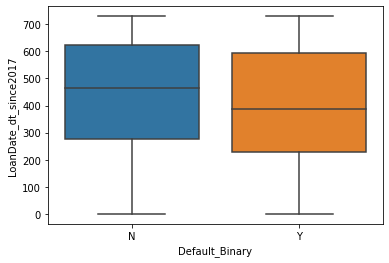

In [ ]:
# the histogram of the data

plt.hist(bond1['LoanDate_dt'], 50, density=True, facecolor='g', alpha=0.75)
plt.xticks(rotation = 90)
plt.show()

# Boxplot
sns.boxplot(data=bond1, x='Default_Binary', y='LoanDate_dt_since2017')

2.1.13 Gender

The 'Undefined' gender category that represents about 4.4% of the records has a much higher default rate (76%) compared with either men or women. It appears the 'Undefined' category could be problem with lack of data collection rather than an actual attribute of the borrower.

In [ ]:
show_counts('Gender_c')
print()

show_default_pct(bond1.loc[bond1['Gender_c'] == 'Male'], 'Male')
show_default_pct(bond1.loc[bond1['Gender_c'] == 'Woman'], 'Woman')
show_default_pct(bond1.loc[bond1['Gender_c'] == 'Undefined'], 'Undefined')

Male         34188   79.4%
Woman         6935   16.1%
Undefined      1913   4.4%
Name: Gender_c, dtype: object

Male - Default rate 51.7%
Woman - Default rate 51.9%
Undefined - Default rate 76.2%


##3. Problem Definition

We would like to be able to predict whether future loans will result in default. This can be seen as a classification problem in which we have a binary response. We would like to develop a model that classifies loans as default or non-default based on the attributes that are provided.

###3.1 Evaluation Metrics
To judge out classifiers, we will split the data into a train and test set. After training each classified on the training data, we will test its performance on the test data.

In [ ]:
# Split into train and test
from sklearn.model_selection import train_test_split
X_training, X_testing, Y_training, Y_testing = train_test_split(bond1, bond1['Default_Binary'], test_size=0.3, random_state=500)

3.2 Modeling Approach

We will start with Logistic Regression, and try out different combinations of features, selecting a model based on accuracy and F1 Score.

Once we have developed a Logistic Regression model, we will also try out K-nearest neighbors and perceptron models, and compare their performance.

4. Feature Extraction/Selection & Model Selection

4.1 Logistic Regression

4.1.1 Logistic Regression - Country Only

As we observed in 2.1.2 that the default rate varies across the three countries in the data, we will start with a logistic regression model that includes country as a predictor. Additionally to account for the different durations of observation, we will include the days from Jan 1 2017 to loan origination date(LoanDate_dt_since2017) in all models as described in 2.1.12.

As a baseline for comparison, we also fit a model using a completely random variable as a predictor and compare the performance.

In [ ]:
# Import modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Function to run logistic model with specified predictors, and output performance
def run_logistic_model(eval_metrics_list, model_name, model_vars):
    #x_var = 'EmploymentDurationCurrentEmployer'
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_training[model_vars], Y_training)
    Y_testing_predicted = model.predict(X_testing[model_vars])
    Y_testing_predweight_raw = np.exp((np.dot(X_testing[model_vars], model.coef_.T) + model.intercept_).astype(float))
    Y_testing_predweight=Y_testing_predweight_raw/(1+Y_testing_predweight_raw)

    # Compute F1-Score, Recall, Precision and Accuracy
    metric_f1_score = round(f1_score(Y_testing, Y_testing_predicted, average='weighted'), 3) # f1_score
    metric_precision = round(precision_score(Y_testing, Y_testing_predicted, average='weighted'), 3) # Precision
    metric_recall = round(recall_score(Y_testing, Y_testing_predicted, average='weighted'), 3) # Recall
    metric_accuracy = round(accuracy_score(Y_testing, Y_testing_predicted), 3) # Accuracy

    # Save metrics
    eval_metrics_list.append([model_name, metric_f1_score, metric_precision, metric_recall, metric_accuracy])
    return(eval_metrics_list)

In [ ]:
# Set up list to store evaluation metrics
names = ['model', 'F1-Score', 'Recall', 'Precision', 'Accuracy']
eval_metrics_list1 = []

#########################################################################
# Logistic regression - random
eval_metrics_list1 = run_logistic_model(eval_metrics_list = eval_metrics_list1, 
                                       model_name = 'Logistic - Random',
                                       model_vars = ['randomvar'])

# Logistic regression - country
eval_metrics_list1 = run_logistic_model(eval_metrics_list = eval_metrics_list1, 
                                       model_name = 'Logistic - Country Only',
                                       model_vars = ['Country_EE', 'Country_ES', 'Country_FI', 'LoanDate_dt_since2017'])


# Convert the list containing the metrics to a Pandas dataframe and print
eval_metrics = pd.DataFrame(eval_metrics_list1, columns=names)
eval_metrics.head()


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model,F1-Score,Recall,Precision,Accuracy
0,Logistic - Random,0.363,0.277,0.526,0.526
1,Logistic - Country Only,0.629,0.648,0.633,0.633


Using countries as predictor variables increases the accuracy from 52.6% for the baseline random model up to 63.3%

4.1.1 Logistic Regression - Model 1

From the exploratory analysis in section 2., four variables that displayed correlation with the default rate are home ownership type, education level, newness to credit, and financial verification type. 

Plotting cross tables, there is correlation between education level and home ownership type and between new credit customer and verification type, though a weak correlation, nothing close to collinearity.

In [ ]:
# Correlation between education and home ownership type
print(pd.crosstab(bond1['HomeOwnershipType_simple'], bond1['Education_simple']))
print()
print('% Secondary Education among Owner = ' + str(round(100*16609/(7053+16609), 1))+'%')
print('% Secondary Education among Other = ' + str(round(100*5828/(2741+5828), 1))+'%')
print('% Secondary Education among Tenant = ' + str(round(100*6945/(3856+6945), 1))+'%')

Education_simple             Primary Education  Secondary Education
HomeOwnershipType_simple                                           
                          3                  0                    0
Other                     0               2741                 5828
Owner                     0               7053                16609
Tenant                    1               3856                 6945

% Secondary Education among Owner = 70.2%
% Secondary Education among Other = 68.0%
% Secondary Education among Tenant = 64.3%


In [ ]:
# Correlation between education and home ownership type
print(pd.crosstab(bond1['NewCreditCustomer'], bond1['VerificationType_binary']))
print()
print('% Verified among New Credit Customers = ' + str(round(100*12861/(6740+12861), 1))+'%')
print('% Verified among Others = ' + str(round(100*11318/(12117+11318), 1))+'%')

VerificationType_binary  Unverified  Verified
NewCreditCustomer                            
False                         12117     11318
True                           6740     12861

% Verified among New Credit Customers = 65.6%
% Verified among Others = 48.3%


Adding these four variables to the model, we fit the logistic regression model.

In [ ]:
eval_metrics_list2 = eval_metrics_list1.copy()

#########################################################################
# Logistic regression - Model 1
model_vars_model1 = ['Country_EE', 'Country_ES', 'Country_FI', 'LoanDate_dt_since2017',
                     'HomeOwnershipType_simple_Other', 'HomeOwnershipType_simple_Owner', 'HomeOwnershipType_simple_Tenant', # Home ownership type
                     'Education_simple_Primary Education', 'Education_simple_Secondary Education', # Education type
                     'NewCreditCustomer', # new credit customer
                     'VerificationType_binary_Verified', 'VerificationType_binary_Unverified'] # type of financial verification

eval_metrics_list2 = run_logistic_model(eval_metrics_list = eval_metrics_list2, 
                                       model_name = 'Logistic - Model 1',
                                       model_vars = model_vars_model1)


# Convert the list containing the metrics to a Pandas dataframe and print
eval_metrics = pd.DataFrame(eval_metrics_list2, columns=names)
eval_metrics.head()


,model,F1-Score,Recall,Precision,Accuracy
0,Logistic - Random,0.363,0.277,0.526,0.526
1,Logistic - Country Only,0.629,0.648,0.633,0.633
2,Logistic - Model 1,0.645,0.648,0.645,0.645


Adding thse four predictors of home ownership type, education level, newness to credit, and financial verification type improve the prediction accuracy from 63.3% to 64.5%.

4.1.2 Logistic Regression - Model 2

In the exploratory analysis, the two variables that displayed some weak correlation with default rate are the loan monthly payment and whether the  borrower was a retiree. We add these variables to the logistic regression model

In [ ]:
eval_metrics_list3 = eval_metrics_list2.copy()

#########################################################################
# Logistic regression - Model 2
model_vars_model2 = ['Country_EE', 'Country_ES', 'Country_FI', 'LoanDate_dt_since2017',
                     'HomeOwnershipType_simple_Other', 'HomeOwnershipType_simple_Owner', 'HomeOwnershipType_simple_Tenant', # Home ownership type
                     'Education_simple_Primary Education', 'Education_simple_Secondary Education', # Education type
                     'NewCreditCustomer', # new credit customer
                     'VerificationType_binary_Verified', 'VerificationType_binary_Unverified', # type of financial verification
                     'MonthlyPayment_log', # Monthly payment amount for loan
                     'EmploymentDuration_Retiree', # Retiree status
                     ]
                     
eval_metrics_list3 = run_logistic_model(eval_metrics_list = eval_metrics_list3, 
                                       model_name = 'Logistic - Model 2',
                                       model_vars = model_vars_model2)

# Convert the list containing the metrics to a Pandas dataframe and print
eval_metrics = pd.DataFrame(eval_metrics_list3, columns=names)
eval_metrics.head()


,model,F1-Score,Recall,Precision,Accuracy
0,Logistic - Random,0.363,0.277,0.526,0.526
1,Logistic - Country Only,0.629,0.648,0.633,0.633
2,Logistic - Model 1,0.645,0.648,0.645,0.645
3,Logistic - Model 2,0.645,0.648,0.645,0.645


The addition of monthly payment and retiree status do not improve the accuracy. In fact, they have no affect on any of the metrics.

4.1.2 Logistic Regression - Model 3

We try adding the last variables of total income, age, and time to first payment, though they did not show correlation with default rate in the exploratory analysis, to see how the model performance is affected.

Because the correlation of gender with default rate appeared to be a spurious association related to missing data, as described in 2.1.13, we do not include gender in any model.

In [ ]:
eval_metrics_list4 = eval_metrics_list3.copy()

#########################################################################
# Logistic regression - Model 3
model_vars_model3 = ['Country_EE', 'Country_ES', 'Country_FI', 'LoanDate_dt_since2017',
                     'HomeOwnershipType_simple_Other', 'HomeOwnershipType_simple_Owner', 'HomeOwnershipType_simple_Tenant', # Home ownership type
                     'Education_simple_Primary Education', 'Education_simple_Secondary Education', # Education type
                     'NewCreditCustomer', # new credit customer
                     'VerificationType_binary_Verified', 'VerificationType_binary_Unverified', # type of financial verification
                     'MonthlyPayment_log', # Monthly payment amount for loan
                     'EmploymentDuration_Retiree', # Retiree status
                     'IncomeTotal_log', # Total income
                     'Age', # Age
                     'TimeToFirstPayment' # Time To First Payment
                     ]

eval_metrics_list4 = run_logistic_model(eval_metrics_list = eval_metrics_list4, 
                                       model_name = 'Logistic - Model 3',
                                       model_vars = model_vars_model3
                                        )

# Convert the list containing the metrics to a Pandas dataframe and print
eval_metrics = pd.DataFrame(eval_metrics_list4, columns=names)
eval_metrics.head()


,model,F1-Score,Recall,Precision,Accuracy
0,Logistic - Random,0.363,0.277,0.526,0.526
1,Logistic - Country Only,0.629,0.648,0.633,0.633
2,Logistic - Model 1,0.645,0.648,0.645,0.645
3,Logistic - Model 2,0.645,0.648,0.645,0.645
4,Logistic - Model 3,0.646,0.648,0.645,0.645


The addition of these last few variables have no further affect on the accuracy. 

4.1.2 Logistic Regression - Conclusions
Based on the metrics, out of the logistic regression models, we prefer Model 1 that includes country, home ownership type, education level, newness to credit, and financial verification type. This model provides the maximal accuracy. The addition of further variables does not improve the accuracy, so we prefer the more parsimonious Model 1 over Model 2 or Model 3.

4.2 Separate Logistic Regressions

It is possible that the effects of each predictor may behave differently in the three different countries, so we also try fitting three separate logistic regression models, one for each country with the same predictors as Model 1 and comparing the results.

In [ ]:
# Split train and test data by country

# X Training
X_training_EE = X_training.loc[X_training['Country'] == 'EE']
X_training_FI = X_training.loc[X_training['Country'] == 'FI']
X_training_ES = X_training.loc[X_training['Country'] == 'ES']
# X Testing
X_testing_EE = X_testing.loc[X_testing['Country'] == 'EE']
X_testing_FI = X_testing.loc[X_testing['Country'] == 'FI']
X_testing_ES = X_testing.loc[X_testing['Country'] == 'ES']
# Y Training
Y_training_EE = Y_training.loc[X_training['Country'] == 'EE']
Y_training_FI = Y_training.loc[X_training['Country'] == 'FI']
Y_training_ES = Y_training.loc[X_training['Country'] == 'ES']
# Y Testing
Y_testing_EE = Y_testing.loc[X_testing['Country'] == 'EE']
Y_testing_FI = Y_testing.loc[X_testing['Country'] == 'FI']
Y_testing_ES = Y_testing.loc[X_testing['Country'] == 'ES']

Y_testing_country = pd.concat((Y_testing_EE, Y_testing_FI, Y_testing_ES))

In [ ]:
# Separate logistic model for each country
def run_logistic_separate_model(eval_metrics_list, model_name, model_vars):
    #x_var = 'EmploymentDurationCurrentEmployer'
    
    model_EE = LogisticRegression(max_iter=1000)
    model_EE.fit(X_training_EE[model_vars], Y_training_EE)
    model_FI = LogisticRegression(max_iter=1000)
    model_FI.fit(X_training_FI[model_vars], Y_training_FI)
    model_ES = LogisticRegression(max_iter=1000)
    model_ES.fit(X_training_ES[model_vars], Y_training_ES)

    Y_testing_EE_predicted = model_EE.predict(X_testing_EE[model_vars])
    Y_testing_FI_predicted = model_FI.predict(X_testing_FI[model_vars])
    Y_testing_ES_predicted = model_ES.predict(X_testing_ES[model_vars])

    print(type(Y_testing_EE_predicted))
    Y_testing_country_predicted = np.concatenate((Y_testing_EE_predicted, Y_testing_FI_predicted, Y_testing_ES_predicted))

    # Compute F1-Score, Recall, Precision and Accuracy
    metric_f1_score = round(f1_score(Y_testing_country, Y_testing_country_predicted, average='weighted'), 3) # f1_score
    metric_precision = round(precision_score(Y_testing_country, Y_testing_country_predicted, average='weighted'), 3) # Precision
    metric_recall = round(recall_score(Y_testing_country, Y_testing_country_predicted, average='weighted'), 3) # Recall
    metric_accuracy = round(accuracy_score(Y_testing_country, Y_testing_country_predicted), 3) # Accuracy

    # Save metrics
    eval_metrics_list.append([model_name, metric_f1_score, metric_precision, metric_recall, metric_accuracy])
    return(eval_metrics_list)


In [ ]:
eval_metrics_list_sep1 = eval_metrics_list4.copy()

#########################################################################
# Logistic regression - Model 2
eval_metrics_list_sep1 = run_logistic_separate_model(eval_metrics_list = eval_metrics_list_sep1, 
                                       model_name = 'Logistic Separate - Model 1',
                                       model_vars = model_vars_model1)

# Convert the list containing the metrics to a Pandas dataframe and print
eval_metrics = pd.DataFrame(eval_metrics_list_sep1, columns=names)
print(eval_metrics)


<class 'numpy.ndarray'>
                         model  F1-Score  Recall  Precision  Accuracy
0            Logistic - Random     0.363   0.277      0.526     0.526
1      Logistic - Country Only     0.629   0.648      0.633     0.633
2           Logistic - Model 1     0.645   0.648      0.645     0.645
3           Logistic - Model 2     0.645   0.648      0.645     0.645
4           Logistic - Model 3     0.646   0.648      0.645     0.645
5  Logistic Separate - Model 1     0.646   0.648      0.646     0.646


The method of fitting a separate logistic regression model for each country provides nearly the same metrics as the model with a single logistic regression (i.e. accuracy of 64.6% vs 64.5%), so we prefer the single-model method due to simplicity.

4.3 K Nearest Neighbors

4.3.1 K Nearest Neighbors - Choosing K 

We try fitting K Nearest Neighbors Model for several values of K, using the same predictors as logistic model 1.

In [ ]:
# Standardize data. Neccessary in KNN unlike Logistic regression.
from sklearn.preprocessing import StandardScaler
num_vars = ['MonthlyPayment_log', 'IncomeTotal_log', 'Age', 'NoOfPreviousLoansBeforeLoan', 'TimeToFirstPayment', 'LoanDate_dt_since2017']
bond1_std = bond1.copy()
bond1_std[num_vars] = StandardScaler().fit_transform(bond1_std[num_vars])

X_training, X_testing, Y_training, Y_testing = train_test_split(bond1_std, bond1_std['Default_Binary'], test_size=0.3, random_state=500)

In [ ]:
# KNN Model
def run_KNN_model(eval_metrics_list_KNN, k, model_num, model_vars):
    model_vars = model_vars
    model_name = 'Model ' + str(model_num) + ', KNN ' + str(k)
    
    modelKNN = KNeighborsClassifier(n_neighbors=k) # Use k nearest neighbors
    modelKNN.fit(X_training[model_vars], Y_training)
    Y_testing_predicted = modelKNN.predict(X_testing[model_vars])

    # Compute F1-Score, Recall, Precision and Accuracy
    metric_f1_score = round(f1_score(Y_testing, Y_testing_predicted, average='weighted'), 3) # f1_score
    metric_precision = round(precision_score(Y_testing, Y_testing_predicted, average='weighted'), 3) # Precision
    metric_recall = round(recall_score(Y_testing, Y_testing_predicted, average='weighted'), 3) # Recall
    metric_accuracy = round(accuracy_score(Y_testing, Y_testing_predicted), 3) # Accuracy
    eval_metrics_list_KNN.append([model_name, metric_f1_score, metric_precision, metric_recall, metric_accuracy])
    return(eval_metrics_list_KNN)

In [ ]:
eval_metrics_list_KNN1 = eval_metrics_list_sep1.copy()
from sklearn.neighbors import KNeighborsClassifier

eval_metrics_list_KNN1 = run_KNN_model(eval_metrics_list_KNN = eval_metrics_list_KNN1, k = 30, model_num = 1, model_vars = model_vars_model1)
eval_metrics_list_KNN1 = run_KNN_model(eval_metrics_list_KNN = eval_metrics_list_KNN1, k = 40, model_num = 1, model_vars = model_vars_model1)
eval_metrics_list_KNN1 = run_KNN_model(eval_metrics_list_KNN = eval_metrics_list_KNN1, k = 50, model_num = 1, model_vars = model_vars_model1)

# Convert the list containing the metrics to a Pandas dataframe
eval_metrics = pd.DataFrame(eval_metrics_list_KNN1, columns=names)
eval_metrics

,model,F1-Score,Recall,Precision,Accuracy
0,Logistic - Random,0.363,0.277,0.526,0.526
1,Logistic - Country Only,0.629,0.648,0.633,0.633
2,Logistic - Model 1,0.645,0.648,0.645,0.645
3,Logistic - Model 2,0.645,0.648,0.645,0.645
4,Logistic - Model 3,0.646,0.648,0.645,0.645
5,Logistic Separate - Model 1,0.646,0.648,0.646,0.646
6,"Model 1, KNN 30",0.642,0.644,0.642,0.642
7,"Model 1, KNN 40",0.644,0.646,0.644,0.644
8,"Model 1, KNN 50",0.642,0.644,0.642,0.642


Comparing the metrics, K=40 appears to be a reasonable value for K.


4.3.2 K Nearest Neighbors - Choosing Predictors
We try the K=40 model for the predictors used in logistic models 2, and 3.

In [ ]:
eval_metrics_list_KNN2 = eval_metrics_list_KNN1.copy()
from sklearn.neighbors import KNeighborsClassifier

eval_metrics_list_KNN2 = run_KNN_model(eval_metrics_list_KNN = eval_metrics_list_KNN2, k = 40, model_num = 2, model_vars = model_vars_model2)
eval_metrics_list_KNN2 = run_KNN_model(eval_metrics_list_KNN = eval_metrics_list_KNN2, k = 40, model_num = 3, model_vars = model_vars_model3)

# Convert the list containing the metrics to a Pandas dataframe
eval_metrics = pd.DataFrame(eval_metrics_list_KNN2, columns=names)
eval_metrics

,model,F1-Score,Recall,Precision,Accuracy
0,Logistic - Random,0.363,0.277,0.526,0.526
1,Logistic - Country Only,0.629,0.648,0.633,0.633
2,Logistic - Model 1,0.645,0.648,0.645,0.645
3,Logistic - Model 2,0.645,0.648,0.645,0.645
4,Logistic - Model 3,0.646,0.648,0.645,0.645
5,Logistic Separate - Model 1,0.646,0.648,0.646,0.646
6,"Model 1, KNN 30",0.642,0.644,0.642,0.642
7,"Model 1, KNN 40",0.644,0.646,0.644,0.644
8,"Model 1, KNN 50",0.642,0.644,0.642,0.642
9,"Model 2, KNN 40",0.647,0.648,0.647,0.647


Unlike the logistic regression model, the the KNN model performs better for models 2 and 3 than model 1. The extra variables lend the KNN model slightly better prediction power though they are only slightly correlated with the default rate individually.

4.4 Perceptron Model

4.4.1 Perceptron Model - Choosing Layer Structure
We try fitting Perceptron Models for several differing layer structures, using the same predictors as logistic model 1.




In [ ]:
from sklearn.neural_network import MLPClassifier

# Perceptron model
def run_MLPC_model(eval_metrics_list_MLPC, model_name, hidden_layer_sizes, model_vars):
    MLP = MLPClassifier(activation='logistic', solver='lbfgs', 
                        hidden_layer_sizes=hidden_layer_sizes, max_iter=5000)
    MLP.fit(X_training[model_vars], Y_training)
    Y_testing_predicted=MLP.predict(X_testing[model_vars])

    metric_f1_score = f1_score(Y_testing, Y_testing_predicted, average='weighted') # f1_score
    metric_precision = precision_score(Y_testing, Y_testing_predicted, average='weighted') # Precision
    metric_recall = recall_score(Y_testing, Y_testing_predicted, average='weighted') # Recall
    metric_accuracy = accuracy_score(Y_testing, Y_testing_predicted) # Accuracy

    eval_metrics_list_MLPC.append([model_name, metric_f1_score, metric_precision, metric_recall, metric_accuracy])
    return(eval_metrics_list_MLPC)

In [ ]:
eval_metrics_list_MLPC1 = eval_metrics_list_KNN2.copy()

eval_metrics_list_MLPC1 = run_MLPC_model(eval_metrics_list_MLPC=eval_metrics_list_MLPC1, model_name = 'Model 1, MLPC_5',
                                       hidden_layer_sizes=(5,), model_vars = model_vars_model1)
eval_metrics_list_MLPC1 = run_MLPC_model(eval_metrics_list_MLPC=eval_metrics_list_MLPC1, model_name = 'Model 1, MLPC_7',
                                       hidden_layer_sizes=(7,), model_vars = model_vars_model1)
eval_metrics_list_MLPC1 = run_MLPC_model(eval_metrics_list_MLPC=eval_metrics_list_MLPC1, model_name = 'Model 1, MLPC_10',
                                       hidden_layer_sizes=(10,), model_vars = model_vars_model1)
eval_metrics_list_MLPC1 = run_MLPC_model(eval_metrics_list_MLPC=eval_metrics_list_MLPC1, model_name = 'Model 1, MLPC_5_5',
                                       hidden_layer_sizes=(5,5,), model_vars = model_vars_model1)
eval_metrics_list_MLPC1 = run_MLPC_model(eval_metrics_list_MLPC=eval_metrics_list_MLPC1, model_name = 'Model 1, MLPC_7_7',
                                       hidden_layer_sizes=(7,7,), model_vars = model_vars_model1)
eval_metrics_list_MLPC1 = run_MLPC_model(eval_metrics_list_MLPC=eval_metrics_list_MLPC1, model_name = 'Model 1, MLPC_10_10',
                                       hidden_layer_sizes=(10,10,), model_vars = model_vars_model1)


# Convert the list containing the metrics to a Pandas dataframe
eval_metrics = pd.DataFrame(eval_metrics_list_MLPC1, columns=names)
eval_metrics

,model,F1-Score,Recall,Precision,Accuracy
0,Logistic - Random,0.363000,0.277000,0.526000,0.526000
1,Logistic - Country Only,0.629000,0.648000,0.633000,0.633000
2,Logistic - Model 1,0.645000,0.648000,0.645000,0.645000
3,Logistic - Model 2,0.645000,0.648000,0.645000,0.645000
4,Logistic - Model 3,0.646000,0.648000,0.645000,0.645000
5,Logistic Separate - Model 1,0.646000,0.648000,0.646000,0.646000
6,"Model 1, KNN 30",0.642000,0.644000,0.642000,0.642000
7,"Model 1, KNN 40",0.644000,0.646000,0.644000,0.644000
8,"Model 1, KNN 50",0.642000,0.644000,0.642000,0.642000
9,"Model 2, KNN 40",0.647000,0.648000,0.647000,0.647000


The Perceptron model with a single layer of seven perceptrons has the optimal test set accuracy among the different layer structures tested.

4.4.2 Perceptron Model - Choosing Predictors
We try the single layer 7 perceptron model for the predictors used in logistic models 2 and 3.

In [ ]:
eval_metrics_list_MLPC2 = eval_metrics_list_MLPC1.copy()

eval_metrics_list_MLPC2 = run_MLPC_model(eval_metrics_list_MLPC=eval_metrics_list_MLPC2, model_name = 'Model 2, MLPC_7',
                                       hidden_layer_sizes=(7,), model_vars = model_vars_model2)
eval_metrics_list_MLPC2 = run_MLPC_model(eval_metrics_list_MLPC=eval_metrics_list_MLPC2, model_name = 'Model 3, MLPC_7',
                                       hidden_layer_sizes=(7,), model_vars = model_vars_model3)


# Convert the list containing the metrics to a Pandas dataframe
eval_metrics = pd.DataFrame(eval_metrics_list_MLPC2, columns=names)
eval_metrics

,model,F1-Score,Recall,Precision,Accuracy
0,Logistic - Random,0.363000,0.277000,0.526000,0.526000
1,Logistic - Country Only,0.629000,0.648000,0.633000,0.633000
2,Logistic - Model 1,0.645000,0.648000,0.645000,0.645000
3,Logistic - Model 2,0.645000,0.648000,0.645000,0.645000
4,Logistic - Model 3,0.646000,0.648000,0.645000,0.645000
5,Logistic Separate - Model 1,0.646000,0.648000,0.646000,0.646000
6,"Model 1, KNN 30",0.642000,0.644000,0.642000,0.642000
7,"Model 1, KNN 40",0.644000,0.646000,0.644000,0.644000
8,"Model 1, KNN 50",0.642000,0.644000,0.642000,0.642000
9,"Model 2, KNN 40",0.647000,0.648000,0.647000,0.647000


Like the KNN model but unlike the logistic regression, the perceptron model performs slightly with the extra variables in models 2 and 3 compared with model 1. The test set prediction accuracy is optimized for the Model 3 predictors.

5. Conclusions


5.1 Findings in Predicted Values

The high dimensionality of the predictors pose some challenge for plotting the predicted values. In this section, we plot a bivariate cross-sections for two of the predictors.

In [ ]:
# Fit the Single-Layer 7-Perceptron model selected in 4.
MLP = MLPClassifier(activation='logistic', solver='lbfgs', hidden_layer_sizes=(7,), max_iter=5000)
MLP.fit(X_training[model_vars_model3], Y_training)

In [ ]:
# Take sample of the testing data for plotting
X_testing_sample = X_testing.sample(2000)
Y_testing_predicted=MLP.predict(X_testing_sample[model_vars_model3])

###5.2.1 Total Income vs Monthly Payment

Red indicates a predicted default, and black represents a predicted non-default.

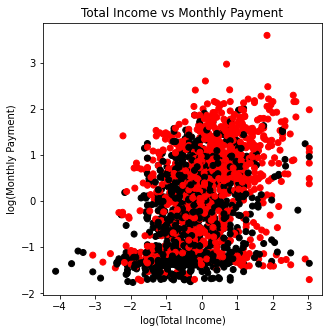

In [ ]:
colors = {'Y':'red', 'N':'black'}
plt.scatter(X_testing_sample['IncomeTotal_log'], X_testing_sample['MonthlyPayment_log'], c = pd.DataFrame(Y_testing_predicted)[0].map(colors))
plt.title("Total Income vs Monthly Payment")
plt.xlabel('log(Total Income)')
plt.ylabel('log(Monthly Payment)')
plt.gcf().set_size_inches(5, 5) # Set figure size
plt.show()

From this plot, we see the highest predicted default rate when the borrower's total monthly income and monthly loan payment are simultaneously high (the high concentration of red dots on the top right). Another trend is the correlation between income and monthly payment (there aren't many points in the top left of either color). We need to remember that the dataset is comprized of loans actually initiated on Bondora and not a randomized trial. If there were more loans indiscriminately approved that fell into the top left of this plot (low income but high loan payment) then it's possible that the default rate would be even higher there, which could affect the fit of the model. So my intuition is that the fact that total income and monthly payment seem to be "working together" to predict default is mainly related to the selection bias in which types of loans are approved by Bondora.


###5.2 Overview of Model Selection from Section 4.
The metrics F1-Score, Recall, Precision, and Accuracy listed for all classifiers we tested in 4.4.2 are presented again as follows.

Out of the classifier models we tried, the single-layer seven-perceptron model that uses the full set of Model 3 predictors (home ownership type, education level, newness to credit, financial verification type, monthly loan payment, retiree status, total income, age, and time to first payment) simultaneously optimizes all four metrics, reaching a test set prediction accuracy of 65.4%. 

In comparison, the best K Nearest Neighbor model used K=40 with the Model 2 predictors (home ownership type, education level, newness to credit, financial verification type, monthly loan payment, retiree status) and reached a prediction accuracy of 64.7%. The best logistic regression model used the Model 1 predictors (home ownership type, education level, newness to credit, financial verification type) and reached a prediction accuracy of 64.5%.

In this case, it looks like the greated non-linear flexibility of the K-Nearest Neighbor and Perceptron models provided a slightly better fit to the data than did the logistic regression model. These more flexible models may be worth considering genrally in situations like this where there are simultaneously a number of correlated predictors and a large sample size that allows greater models flexibility with risk of overfitting the data.

In [ ]:
eval_metrics

,model,F1-Score,Recall,Precision,Accuracy
0,Logistic - Random,0.363000,0.277000,0.526000,0.526000
1,Logistic - Country Only,0.629000,0.648000,0.633000,0.633000
2,Logistic - Model 1,0.645000,0.648000,0.645000,0.645000
3,Logistic - Model 2,0.645000,0.648000,0.645000,0.645000
4,Logistic - Model 3,0.646000,0.648000,0.645000,0.645000
5,Logistic Separate - Model 1,0.646000,0.648000,0.646000,0.646000
6,"Model 1, KNN 30",0.642000,0.644000,0.642000,0.642000
7,"Model 1, KNN 40",0.644000,0.646000,0.644000,0.644000
8,"Model 1, KNN 50",0.642000,0.644000,0.642000,0.642000
9,"Model 2, KNN 40",0.647000,0.648000,0.647000,0.647000


5.3 Final Thoughts

As mentioned in 4.1.1, the accuracy for the completely random model is 52.6% and the accuracy for the model that only uses country is %63.3. Based on these accuracies, we conclude that the predictor variables that we are including in our modelin contain sufficient information to improve the by-country prediction by several percent, there is a large amount of uncertainty that remains in our classifiers. If we were employed by Bondora and wanted to improve upon this modeling approaches, the priority would be placed on gathering more sources of information and improving data collection, as opposed to trying other modeling approaches.

One major weakness of our outcome variable (default status) is the different lengths of observation periods for loans that were initialized on different dates. We controlled for this by dropping loans that initialized after 2018 and also including the date of initiation as a predictor variable. However, for future modeling, we would recommend creating a derived variable "default status after 1 years" to use as the outcome variable to ensure comparability between the loans.

Also, as mentioned in 5.2.1, the data used in this analys consists of loans that were actually initiated on Bondora, a peer-to-peer lending platform. When we assess default risk, we need to remember that the parties that agree to each loan are actively gauging the default risk as they enter the deals. The peer lenders are less likely to enter loans they think are risky and likewise Bondora the platform may have rules against loans they deem too risky. Thus the loans in this data are far from a random sample from the predictors we used! All classifiers based on this data are wedded to the conditions in Bondora at the time of data collection (2017-2018). We gauged our best classifier as around 65.4% accurate. However, if there are any significant changes to the Bondora platform rules, the demographics the platform serves, macroeconomic conditions such as interest rate, and so on, then we would expect that our classifier would quickly become outdated, and would need to be continuously retrained on newer data.